In [11]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical,load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [12]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [13]:
filenames=os.listdir("./dogsCats_dataset/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [14]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [21]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15


In [63]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dogsCats_dataset/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogsCats_dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

# test_generator = train_datagen.flow_from_dataframe(train_df,
#                                                  "./dogsCats_dataset/test/",x_col='filename',y_col='category',
#                                                  target_size=Image_Size,
#                                                  class_mode='categorical',
#                                                  batch_size=batch_size)
test_generator = train_datagen.flow_from_dataframe(test_df, "./dogsCats_dataset/test/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [25]:
epochs=2
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\welcome\AppData\Local\Temp\ipykernel_14600\1018799772.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
1333/1333 [==============================] - 1369s 1s/step - loss: 0.7338 - accuracy: 0.6351 - val_loss: 0.5566 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 2/2
1333/1333 [==============================] - 1205s 904ms/step - loss: 0.5677 - accuracy: 0.7113 - val_loss: 0.4916 - val_accuracy: 0.7682 - lr: 0.0010


In [26]:
model.save("model1_catsVSdogs_2epoch.h5")

In [64]:
test_filenames = os.listdir("./dogsCats_dataset/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [65]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\welcome\AppData\Local\Temp\ipykernel_14600\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: './dogsCats_dataset/test/dog1.jpg'
Traceback (most recent call last):

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\engine\data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\engine\data_adapter.py", line 1048, in generator_fn
    yield x[i]

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\welcome\anaconda3\envs\pytorch1\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './dogsCats_dataset/test/dog1.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_17429]

In [ ]:
# test_df['category'] = np.argmax(predict, axis=-1)
# label_map = dict((v,k) for k,v in train_generator.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)
# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
# sample_test = test_df.head(18)
# sample_test.head()
# plt.figure(figsize=(12, 24))
# for index, row in sample_test.iterrows():
#     filename = row['filename']
#     category = row['category']
#     img = load_img("./dogs-vs-cats/test1/"+filename, target_size=Image_Size)
#     plt.subplot(6, 3, index+1)
#     plt.imshow(img)
#     plt.xlabel(filename + '(' + "{}".format(category) + ')' )
# plt.tight_layout()
# plt.show()

1/1 [==============================] - 0s 142ms/step
prediction:  cat


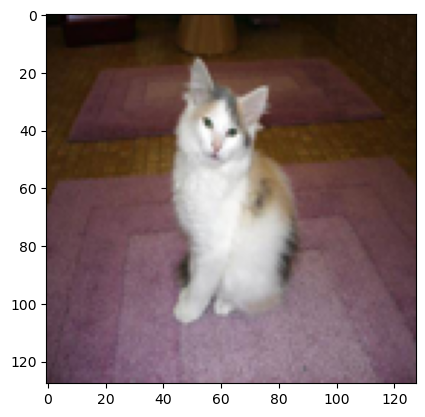

In [67]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
def custom(x):

    im=Image.open(x)
    plt.imshow(im)
    # print(im)
    im=im.resize(Image_Size)
    plt.imshow(im)

    im=np.expand_dims(im,axis=0)
    im=np.array(im)
    im=im/255
    pred=model.predict([im])[0]
    # print(pred,results[pred])
    # print(pred)
    ans=np.argmax(pred)
    print("prediction: ",results[ans])
custom("10.jpg")

1/1 [==============================] - 0s 87ms/step
prediction:  dog


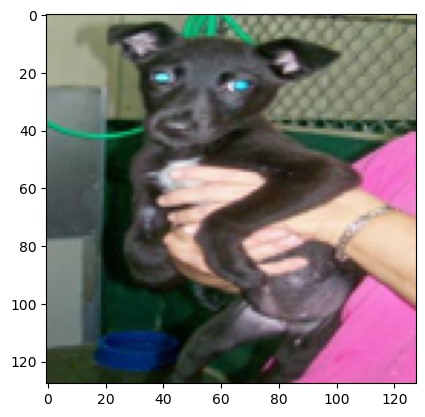

In [68]:
custom("17.jpg")

1/1 [==============================] - 0s 71ms/step
prediction:  cat


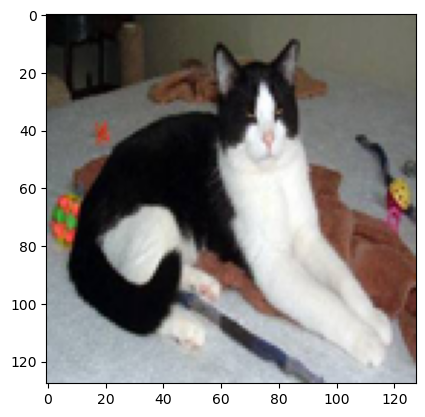

In [69]:
custom("20.jpg")

1/1 [==============================] - 0s 61ms/step
cat


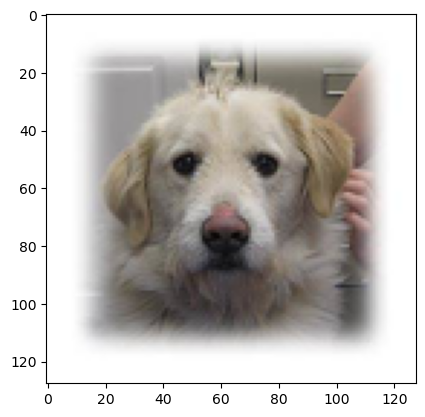

In [52]:
custom("3.jpg")

1/1 [==============================] - 0s 64ms/step
cat


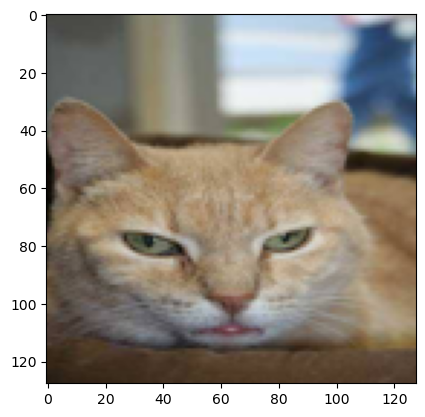

In [53]:
custom("cat.41.jpg")

1/1 [==============================] - 0s 69ms/step
dog


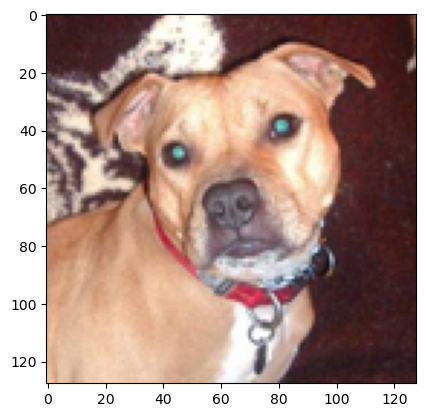

In [54]:
custom("2.jpg")